In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import PROST
PROST.__version__

' 1.1.2 '

In [2]:
# the location of R (used for the mclust clustering)
ENVpath = "your path of PROST_ENV"  
os.environ['R_HOME'] = f'{ENVpath}/lib/R'
os.environ['R_USER'] = f'{ENVpath}/lib/python3.7/site-packages/rpy2'

# init
SEED = 818
PROST.setup_seed(SEED)

# Set the number of clusters
n_clusters = 11

# set dir
input_dir = os.path.join('datasets', 'Stereo-seq/')
output_dir = os.path.join('results','Stereo-seq_result')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)


Filtering genes ...


Trying to set attribute `.var` of view, copying.



Normalization to each gene:


100%|██████████| 8520/8520 [00:02<00:00, 2871.91it/s]



Gaussian filtering for each gene:


100%|██████████| 8520/8520 [18:07<00:00,  7.83it/s]



Binary segmentation for each gene:


100%|██████████| 8520/8520 [00:29<00:00, 285.26it/s]



Spliting subregions for each gene:


100%|██████████| 8520/8520 [01:39<00:00, 85.66it/s]



Computing PROST Index for each gene:


100%|██████████| 8520/8520 [18:21<00:00,  7.74it/s]



PROST Index calculation completed !!

Drawing pictures:


100%|██████████| 1/1 [00:15<00:00, 15.58s/it]



Drawing completed !!


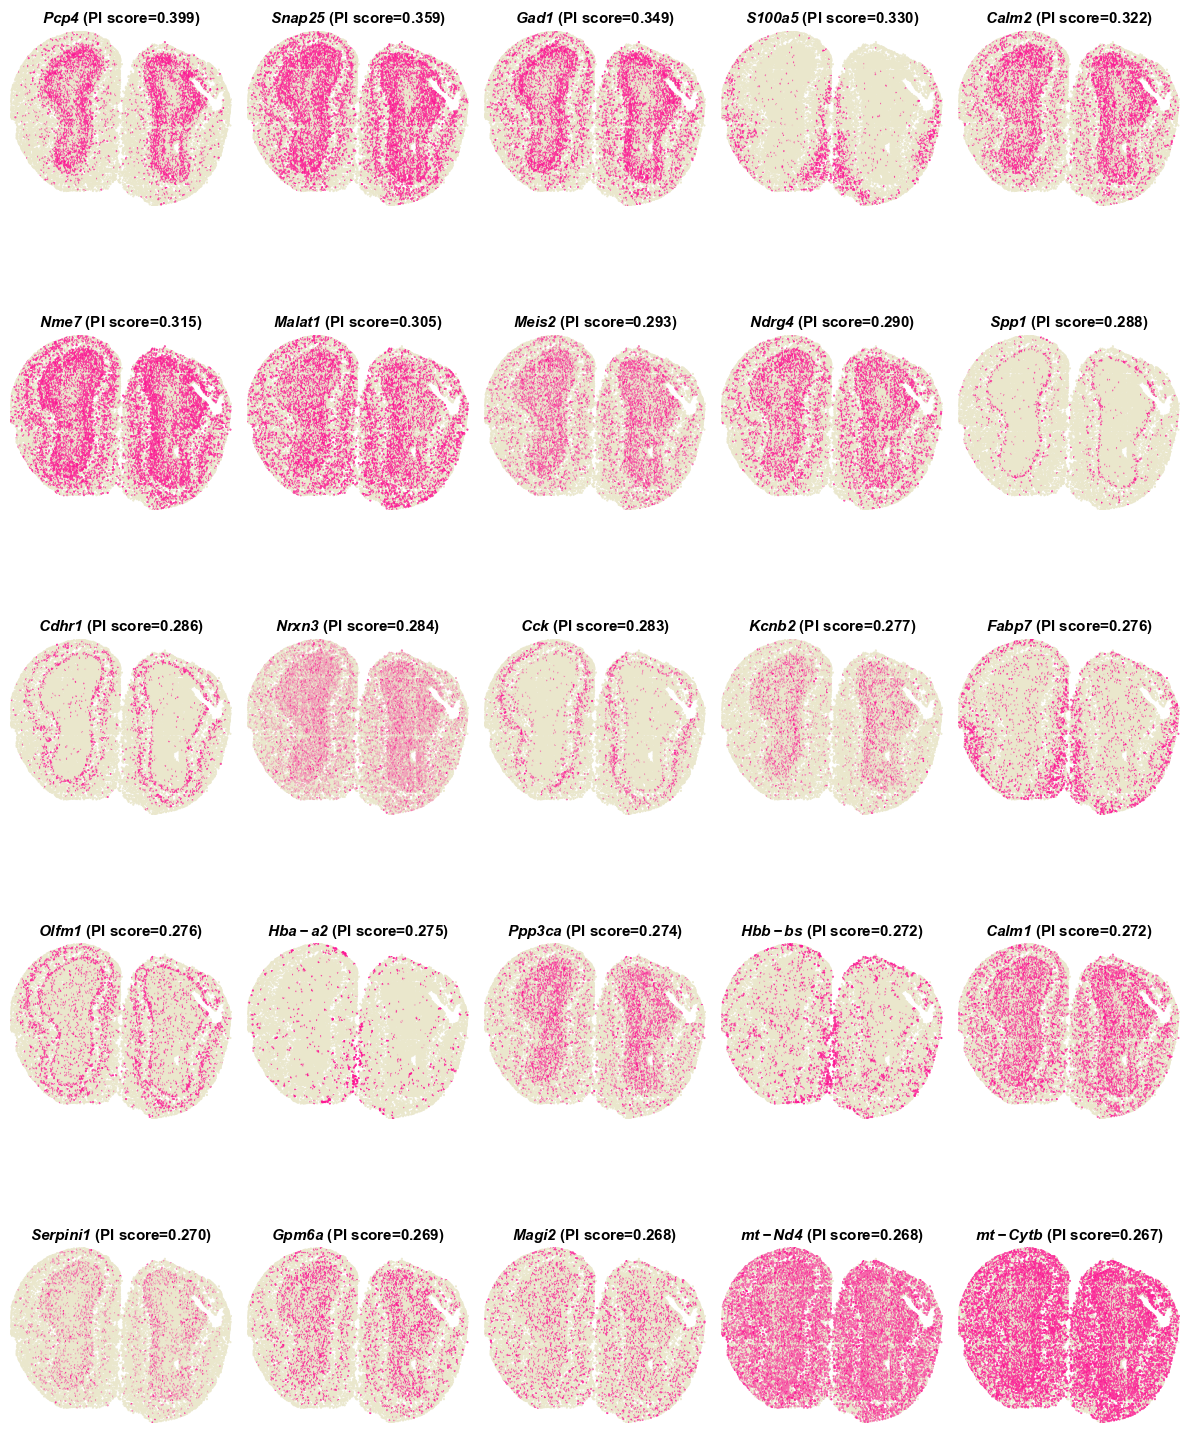

In [3]:
#%% Calculate PI
adata=sc.read(input_dir+"/used_data.h5")

adata = PROST.prepare_for_PI(adata, percentage = 0.01, platform="stereo-seq")
adata = PROST.cal_prost_index(adata, connect_kernel_size=6, neighbors=8, platform="stereo-seq")
adata.write_h5ad(output_dir+"/PI_result.h5")

# Draw SVGs detected by PI
PROST.plot_gene(adata, platform="stereo-seq", size = 0.3, top_n = 25, ncols_each_sheet = 5, nrows_each_sheet = 5,save_path = output_dir)

In [4]:
PROST.setup_seed(SEED)
# Read PI result
adata = sc.read(output_dir+"/PI_result.h5")

# 1.Expression data preprocessing)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata = PROST.feature_selection(adata, save_path = output_dir, by = "prost", n_top_genes = 3000)
adata

View of AnnData object with n_obs × n_vars = 19109 × 2527
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'selected'
    uns: 'binary_image', 'del_index', 'gau_fea', 'locates', 'nor_counts', 'shape', 'subregions', 'log1p'
    obsm: 'spatial'

In [5]:
# 2.Run PROST
PROST.run_prost_clust(adata, 
                        platform="stereo-seq", 
                        min_distance = 50,
                        init="mclust",
                        n_clusters = 11,                     
                        tol = 5e-3,
                        laplacin_filter = True,
                        SEED=SEED,
                        max_epochs = 500,
                        post_processing = False)
# save result
adata.write_h5ad(output_dir + "/PNN_result.h5")
clustering = adata.obs["clustering"]
clustering.to_csv(output_dir + "/clusters.csv",header = False)


Calculating adjacency matrix ...

Running PCA ...
Laplacian Smoothing ...

Initializing cluster centers with mclust, n_clusters known


Epoch: : 501it [3:07:58, 22.51s/it, loss=0.24661717]                         


Clustering completed !!


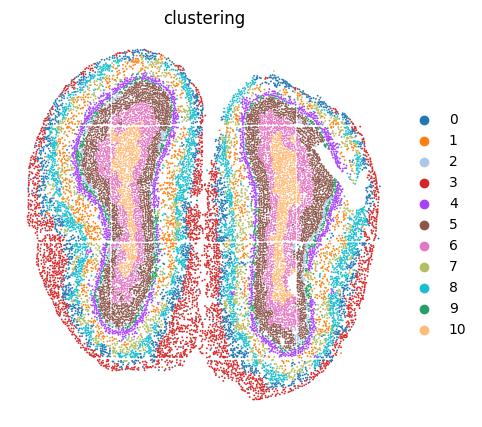

In [6]:
color_list = ['#1f77b4', '#ff7f0e', '#aec7e8', '#d62728', '#aa40fc', '#8c564b',
              '#e377c2', '#b5bd61', '#17becf', '#279e68', '#ffbb78']
adata.uns["clustering"+"_colors"] = color_list
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="clustering",size = 7,s=6, show=False, title='clustering')
plt.axis('off')
plt.savefig(output_dir+"/clustering.png", dpi=600, bbox_inches='tight')

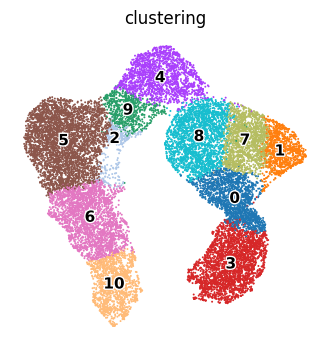

In [7]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pp.neighbors(adata, use_rep="PROST")
sc.tl.umap(adata)
ax = sc.pl.umap(adata, color="clustering", frameon=False, size=8,
                        show = False,legend_loc='on data',legend_fontoutline=2,legend_fontsize=11,
                        )
plt.axis('off')
plt.subplots_adjust()
plt.savefig(output_dir+"/umap.png", dpi=600,bbox_inches='tight')